# Consistency of the "a" trend across individual novels

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [110]:
import numpy as np
import math

from scipy import stats
from boltons.iterutils import pairwise

from lint_analysis.token_offsets import Dataset
from lint_analysis.bin_counts import cache

So, from before, we know that on average the frequency of "a" declines across narrative time, if you just stack the texts on top of each other and count the number of times "a" appears in each percentile. Here, with the raw counts on the Y-axis for the ~27k texts in Gale + Chicago:

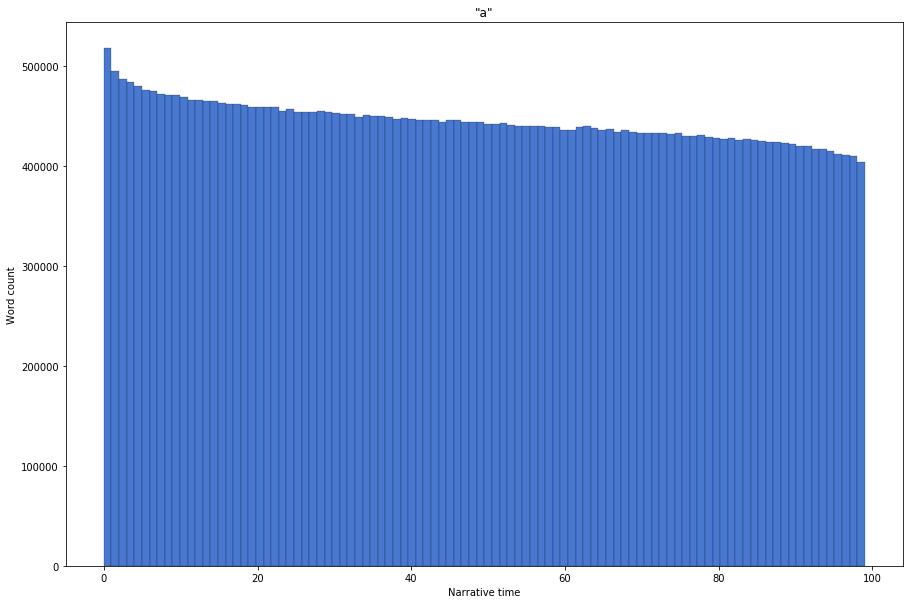

In [117]:
series = cache.token_series('a')

plt.figure(figsize=(15, 10))

plt.title('"a"')
plt.xlabel('Narrative time')
plt.ylabel('Word count')

plt.hist(
    np.arange(len(series)),
    bins=len(series),
    weights=series,
    edgecolor='black',
    linewidth=0.2,
)

plt.show()

Or, as a time series of the relative counts, which shows the trend more clearly:

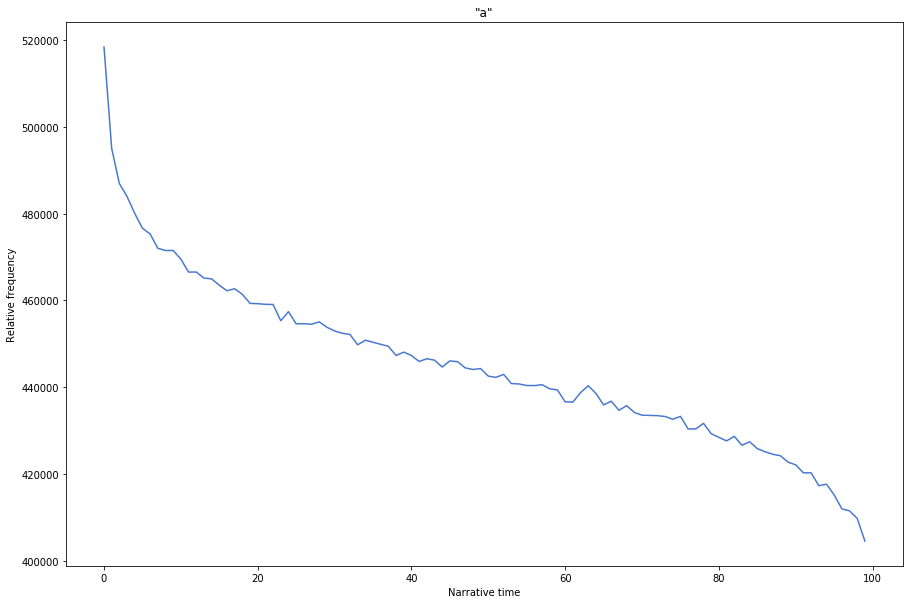

In [119]:
plt.figure(figsize=(15, 10))

series = cache.token_series('a')
plt.plot(series)

plt.title('"a"')
plt.xlabel('Narrative time')
plt.ylabel('Relative frequency')
plt.show()

The problem with this, though, is that we lose all information about how this varies (or doesn't vary) across individual texts in the corpus. In the most pathalogical case - in theory, it could be that "a" is perfectly flat for 90% of the texts in the corpus, and that the downward trend appears very strongly in just 10% of texts, which then completely drive the shape of the aggregate trend.

To check this, we can look at the un-aggregated offsets for "a" inside of each text in the corpus. The `Dataset` class here wraps around a JSON dump from the cluster that contains the 0-1 offsets for each occurrence of "a" in each text. To simplify things, we'll group these offsets into 5 bins, each representing 20% of the text, and then divide by the total frequency of "a" in the entire text to get the proportion of "a" that appears in each 1/5th of the novel.

In [5]:
a = Dataset.from_local('a.json')

In [6]:
def make_bin(offset, bin_count):
    return math.floor(offset * bin_count) if offset < 1 else bin_count-1

In [7]:
counts = []
for text in a.texts():
    
    row = np.zeros(5)
    
    for offset in text['offsets']:
        b = make_bin(offset, len(row))
        row[b] += 1
        
    counts.append(row / sum(row))

In [8]:
counts = np.stack(counts)
counts = np.nan_to_num(counts)

So, we end up with a 26971x5 matrix - one row for each text, and one column for each 20% chunk of the narrative.

In [78]:
counts.shape

(26971, 5)

And where, for example, the first column in the 20th row represents the percentage of all occurrences of "a" in the 20th novel that appear in the first 20%.

In [83]:
counts[20][0]

0.21460506706408347

Under a uniform distribution, the expectation is that this would always be 0.2 - exactly 20% of the a's show up in each 20% of the novel.

Here are the actual distributions for each of the 20% chunks:

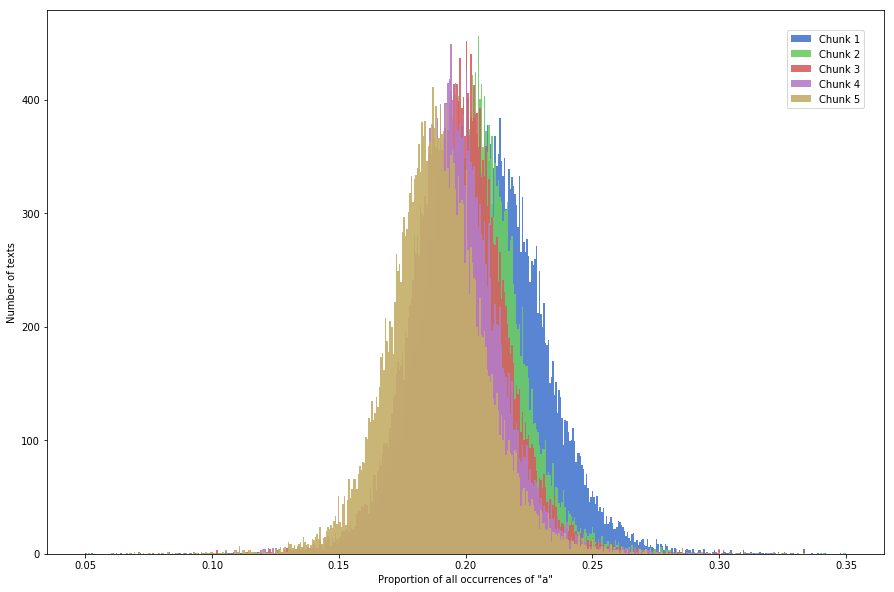

In [91]:
plt.figure(figsize=(15,10))
plt.xlabel('Proportion of all occurrences of "a"')
plt.ylabel('Number of texts')

xlim = (0.05, 0.35)

for i in range(counts.shape[1]):
    _ = plt.hist(counts[:,i], bins=500, range=xlim, alpha=0.9, label=f'Chunk {i+1}')
    
plt.legend(loc=0, borderaxespad=2)

Or, just looking at the first and last bins:

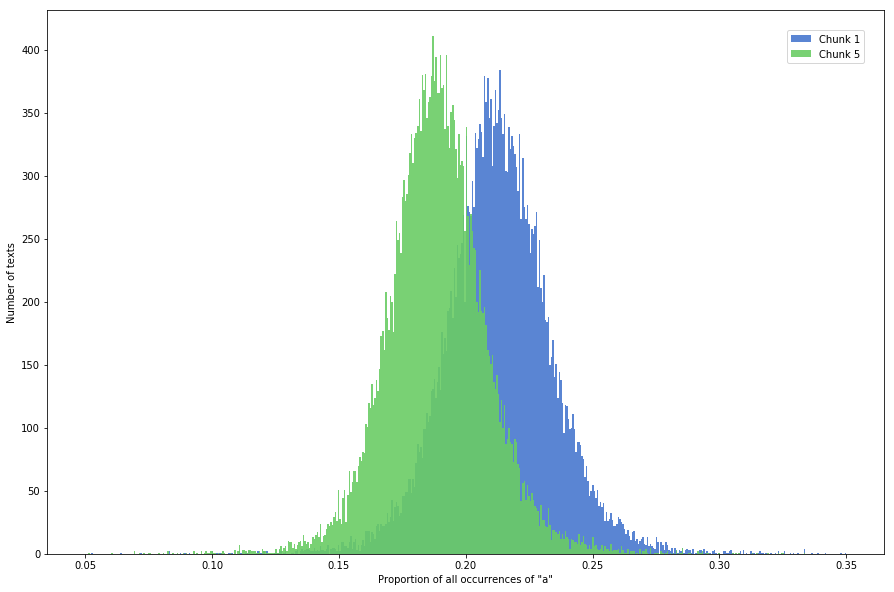

In [94]:
plt.figure(figsize=(15,10))
plt.xlabel('Proportion of all occurrences of "a"')
plt.ylabel('Number of texts')

xlim = (0.05, 0.35)

for i in (0, 4):
    _ = plt.hist(counts[:,i], bins=500, range=xlim, alpha=0.9, label=f'Chunk {i+1}')

plt.legend(loc=0, borderaxespad=2)

So, definitely lots of overlap and novels that buck the trend, the trend is still clear. This is highly significant - using Kolmogorov-Smirnov to test if the samples come from the same distribution, p rounds down to 0:

In [95]:
stats.ks_2samp(counts[:,0], counts[:,4])

Ks_2sampResult(statistic=0.50246561121204247, pvalue=0.0)

But, this might be the oversampling / large N problem again. Let's try downsampling to 1000 texts:

In [96]:
sample = np.random.randint(len(counts), size=1000)

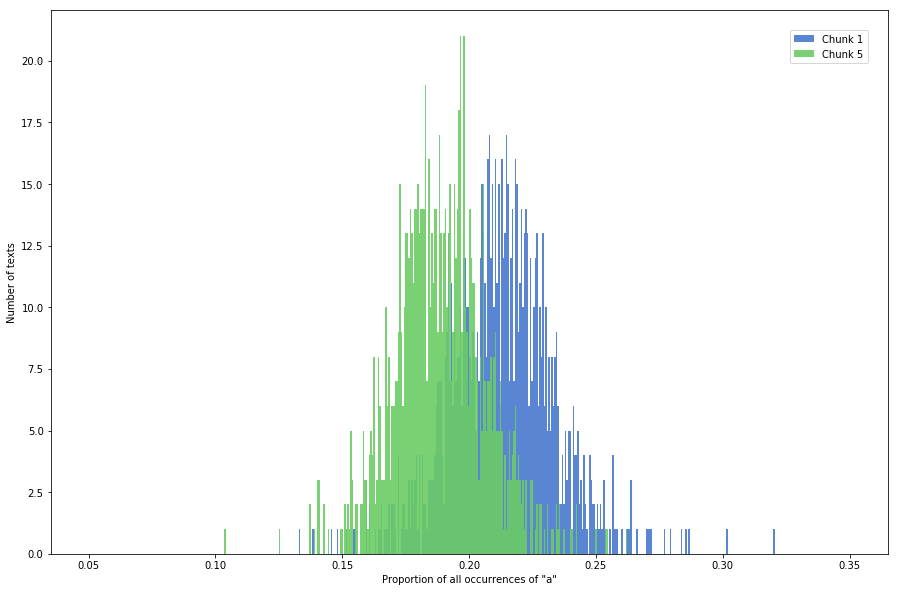

In [99]:
plt.figure(figsize=(15,10))
plt.xlabel('Proportion of all occurrences of "a"')
plt.ylabel('Number of texts')

xlim = (0.05, 0.35)

for i in (0, 4):
    _ = plt.hist(counts[sample][:,i], bins=500, range=xlim, alpha=0.9, label=f'Chunk {i+1}')

plt.legend(loc=0, borderaxespad=2)

Or even just 100:

In [103]:
sample = np.random.randint(len(counts), size=100)

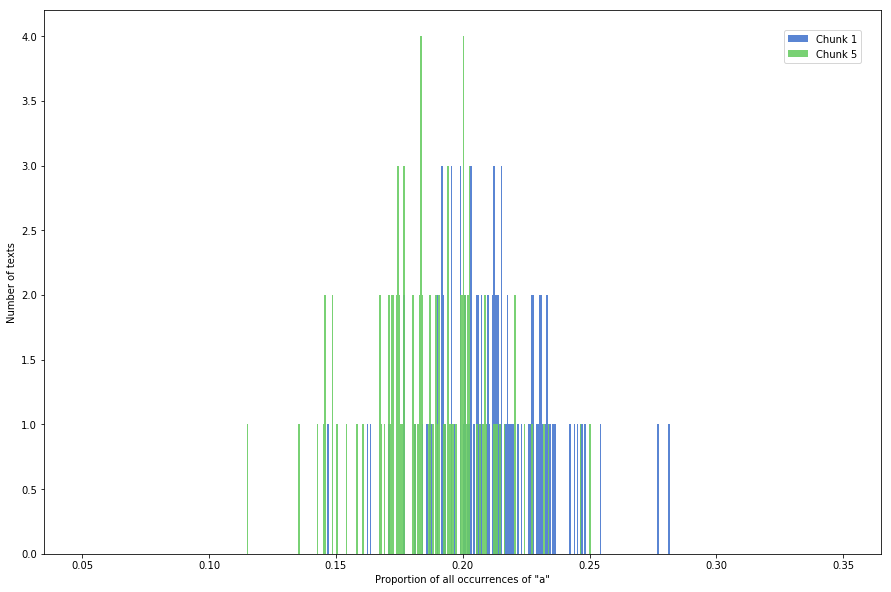

In [104]:
plt.figure(figsize=(15,10))
plt.xlabel('Proportion of all occurrences of "a"')
plt.ylabel('Number of texts')

xlim = (0.05, 0.35)

for i in (0, 4):
    _ = plt.hist(counts[sample][:,i], bins=500, range=xlim, alpha=0.9, label=f'Chunk {i+1}')

plt.legend(loc=0, borderaxespad=2)

With 100, the p-value for the KS statistic between the first and last bins is still at 1e-11:

In [106]:
stats.ks_2samp(counts[sample][:,0], counts[sample][:,4])

Ks_2sampResult(statistic=0.5, pvalue=1.0553445530400741e-11)

And it even stays significant when comparing bins 1-2 and 4-5.

In [115]:
for i1, i2 in pairwise(range(5)):
    print(
        'Bin %d -> %d: %f' % 
        (i1, i2, stats.ks_2samp(counts[sample][:,i1], counts[sample][:,i2]).pvalue)
    )

Bin 0 -> 1: 0.003031
Bin 1 -> 2: 0.343886
Bin 2 -> 3: 0.556017
Bin 3 -> 4: 0.001029
